In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

## Solution strategy for the channel flow

Rearranging the discretized equation so that all unknowns are on the left hand side, on the right hand side there are only known values.

$$v_{i-1} - 2v_i + v_{i+1} = \frac{dP/dx}{\eta}\Delta y^2$$

There is one such equation for each internal grid point. At the boundaries, boundary conditions have to be used, e.g. $v_0 = v_\mathrm{surf}$ and $v_{\mathrm{ny}-1} = v_\mathrm{bott}$.

For five grid points we thus have five equations in total:

$$\begin{eqnarray}
v_0 &    &      &    &     &    &     &   &     & = & v_\mathrm{surf} \\
v_0 & -2 & v_1  & +  & v_2 &    &     &   &     & = & \frac{dP/dx}{\eta}\Delta y^2 \\
    &    & v_1  & -2 & v_2 & +  & v_3 &   &     & = & \frac{dP/dx}{\eta}\Delta y^2 \\
    &    &      &    & v_2 & -2 & v_3 & + & v_4 & = & \frac{dP/dx}{\eta}\Delta y^2 \\
    &    &      &    &     &    &     &   & v_4 & = & v_\mathrm{bott} \\
\end{eqnarray}$$

This system of equations can be written in matrix format as

$$
\begin{pmatrix}
1 & & & & \\ 
1 & -2 &  1 & & \\ 
 & 1 & -2 & 1 & \\ 
 & & 1 & -2 & 1 \\ 
 & & & & 1 \\ 
\end{pmatrix}
\begin{pmatrix}
v_0 \\ 
v_1 \\ 
v_2 \\ 
v_3 \\ 
v_4 \\ 
\end{pmatrix}
=
\begin{pmatrix}
v_\mathrm{surf} \\ 
\frac{dP/dx}{\eta}\Delta y^2 \\ 
\frac{dP/dx}{\eta}\Delta y^2 \\ 
\frac{dP/dx}{\eta}\Delta y^2 \\ 
v_\mathrm{bott} \\ 
\end{pmatrix}
$$

and is typically written with symbols

$$ \mathbf{Ax}=\mathbf{b}$$

Python comes with a module, `scipy.linalg` that includes function `solve`, which can be used to solve this type of systems of linear equations:

    from scipy.linalg import solve
    x = solve(A, b)
  
where `b` has to be a 1-D NumPy array of size `ny`, and includes the numerical values of the right hand side expressions; and `A` a 2-D NumPy array of size (`ny`,`ny`), and includes the numerical coefficients, as above. `x` will then contain the wanted velocity values. The following script utilizes this function to solve the channel flow problem.

### Do

- Complete the following script
    

A is:
 [[ 1.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  1.]] 
b is:
 [ 0.00000000e+00 -1.37340000e-10 -1.37340000e-10 -1.37340000e-10
 -3.16880878e-10]


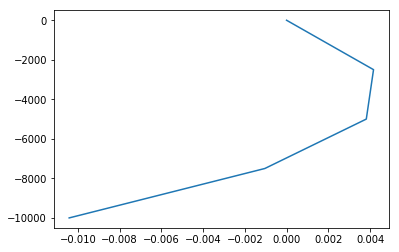

In [4]:
# Define physical parameters
visc = 1e19                    # Viscosity of the rock in the channel, Pa s
dpdx = -2800*9.81*4000/500e3   # Pressure gradient within the channel, Pa m^-1

# Define problem geometry
ny = 5      # number of grid points
L = 10e3    # size of the problem (width of the channel)

# Define values for boundary conditions, m s^-1
vx_surf = 0
vx_bott = -0.01/(60*60*24*365.25)

# Calculate grid spacing and y coordinates
dy = L / (ny-1)
y = np.linspace(0, L, ny)

# Create the empty (zero) coefficient and right hand side arrays
A = np.zeros((ny,ny))  # 2-dimensional array, ny rows, ny columns
b = np.zeros(ny)

# Set B.C. values in the coefficient array and in the r.h.s. array
A[0, 0] = 1
b[0] = vx_surf
A[ny-1, ny-1] = 1
b[ny-1] = vx_bott

# Set remaining (internal grid point) coefficients in the array `A`.
# TODO: Complete the for loop so that it will write the coefficient 
# values in the array `A`. The for loop loops over all the rows
# of the matrix. On each row, you need to fill in three coefficients.
# In python, elements of 2D arrays are referenced to like 'A[row, col]'
for iy in range(1, ny-1):
    A[iy, iy-1] = 1
    A[iy, iy] = -2
    A[iy, iy+1] = 1

# Set remaining (internal grid point) coefficients in the r.h.s. array b
for iy in range(1,ny-1):
    b[iy] = dpdx * dy**2 / visc
    
# For debugging purposes, plot A (if it is small enough) and b
if ny < 15:
    print("A is:\n", A, "\nb is:\n", b.T)
    
# Solve it!
vx = solve(A, b)

# Plot it!
plt.plot(vx * (60*60*25*365.25), -y)
plt.show()


Strain rate in 2D is defined as 

$$\underline{\underline{\dot\epsilon}} = \begin{pmatrix}
\frac{\partial v_x}{\partial x} & \frac{\partial v_x}{\partial y} \\
\frac{\partial v_y}{\partial x} & \frac{\partial v_y}{\partial y} \\
\end{pmatrix}$$

In our case the only relevant component is the shear strain rate $\dot\epsilon_{xy} = \frac{\partial v_x}{\partial y}$.

### Do
 
 - Discretize the shear strain rate expression
 - Complete the script below so that it will loop over all the grid points, calculate the shear strain, and store it in the array `e`
 - How does the resulting plot look like? Note that the _shear stress_ is defined as $\sigma_{xy} = \eta\dot\epsilon_{xy}$. Where is the shear stress smallest?

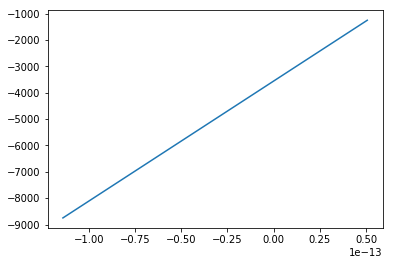

In [9]:
e = np.zeros(ny-1)

# TODO: Write here a for-loop that loops over the grid points
# and calculate the shear strain rate on every step
for iy in range(0, ny-1):
    e[iy] = (vx[iy+1] - vx[iy]) / dy
    
plt.plot(e, -(y[1:] + y[:-1]) / 2.0)
plt.show()

## Velocity boundary conditions

Like in the case of heat equation, the FD formulation for velocity field may have different boundary conditions:

 1. No-slip:
     - Velocity parallel to the surface is fixed at zero
     - $v_x = 0$
 2. Free-slip: 
     - Shear stress at the surface is zero
     - $0 = \sigma_{xy} = \eta\dot\epsilon_{xy} = \eta\frac{\partial v_x}{\partial y} \Rightarrow \frac{\partial v_x}{\partial y} = 0$
 3. Other:
     - Velocity is fixed at non-zero value
     - e.g. $v_x = a \neq 0$, also incoming/outgoing flow ($v_y \neq 0$) possible (in 2D models)
 
 
 We used cases 1 and 3 previously.
 
 ### Do
 
 - Discretize the free-slip boundary condition $\frac{\partial v_x}{\partial y} = 0$
 - If you want to apply this at the upper surface (i.e. at $x=x_0$), how would your system of equations change? How would the coefficients in the matrix $A$ change?
 - Modify your script for the channel flow model, and change the upper surface velocity boundarty condition from $v_x=0$ to a free-slip B.C.
     - How does the resulting velocity plot change?
     - How does the plot for shear strain rate change?

Free-slip velocity b.c. at the upper boundary leads to 

$$
\begin{pmatrix}
-1 & 1 & & & \\ 
1 & -2 &  1 & & \\ 
 & 1 & -2 & 1 & \\ 
 & & 1 & -2 & 1 \\ 
 & & & & 1 \\ 
\end{pmatrix}
\begin{pmatrix}
v_0 \\ 
v_1 \\ 
v_2 \\ 
v_3 \\ 
v_4 \\ 
\end{pmatrix}
=
\begin{pmatrix}
0 \\ 
\frac{dP/dx}{\eta}\Delta y^2 \\ 
\frac{dP/dx}{\eta}\Delta y^2 \\ 
\frac{dP/dx}{\eta}\Delta y^2 \\ 
v_\mathrm{bott} \\ 
\end{pmatrix}
$$

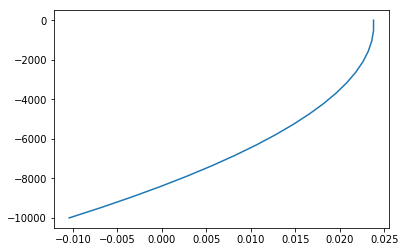

In [48]:
# Define physical parameters
visc = 1e19                    # Pa s
dpdx = -2800*9.81*4000/500e3   # Pa m^-1

# Define problem geometry
ny = 20      # number of grid points
L = 10e3     # size of problem (width of the channel)

# Define values for boundary conditions, m s^-1
vx_surf = 0
vx_bott = -0.01/(60*60*24*365.25)

# Calculate grid spacing and y coordinates
dy = L / (ny-1)
y = np.linspace(0, L, ny)

# Create the empty (zero) coefficient and right hand side arrays
A = np.zeros((ny,ny))
b = np.zeros(ny)

# Set B.C. values in the coefficient array and in the r.h.s. array
A[0, 0] = 1
A[0, 1] = -1
b[0] = 0
A[ny-1, ny-1] = 1
b[ny-1] = vx_bott

# Set remaining (internal grid point) coefficients in the array A
for iy in range(1, ny-1):
    A[iy, iy-1] = 1
    A[iy, iy] = -2
    A[iy, iy+1] = 1

# Set remaining (internal grid point) coefficients in the r.h.s. array b
for iy in range(1,ny-1):
    b[iy] = dpdx * dy**2 / visc
    
# For debugging purposes, plot A (if it is small enough) and b
if ny < 15:
    print("A is:\n", A, "\nb is:\n", b.T)
    
# Solve it!
vx = solve(A, b)

# Plot it!
plt.plot(vx * (60*60*25*365.25), -y)
plt.show()


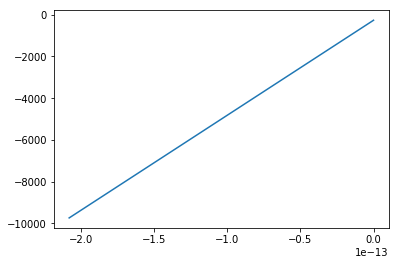

In [50]:
e = np.zeros(ny-1)
ymp = (y[1:] + y[:-1]) / 2.0

for iy in range(0, ny-1):
    e[iy] = (vx[iy+1] - vx[iy]) / dy
    
plt.plot(e, -ymp)
plt.show()